# George image classification
**Profect description:** George classification by image.
# Work plan
- EDA.
- Data augmentation.
- Picking EfficientNet learned on ImageNet dataset.
- Fine-tuning.
- Evaluation.

In [1]:
# Show GPU card characteristics
!nvidia-smi

Wed Feb 17 15:17:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Install  libraries
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

In [3]:
import collections
import math
import os
import requests
import shutil
import sys
from pathlib import Path

import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from ImageDataAugmentor.image_data_augmentor import ImageDataAugmentor
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras import Sequential
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam


print('Python:'.ljust(16), sys.version.split('\n')[0])
print('Numpy:'.ljust(16), np.__version__)
print('Pandas:'.ljust(16), pd.__version__)
print('TensorFlow:'.ljust(16), tf.__version__)
print('Keras:'.ljust(16), tf.keras.__version__)

Python:          3.7.9 | packaged by conda-forge | (default, Dec  9 2020, 21:08:20) 
Numpy:           1.19.5
Pandas:          1.1.5
TensorFlow:      2.4.1
Keras:           2.4.0


In [4]:
# View input files
dirname = '/kaggle/input/georges'
for entryname in os.listdir(dirname):
    print(os.path.join(dirname, entryname))
    
for dirname, _, filenames in os.walk('/kaggle/working'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/georges/non_georges.csv
/kaggle/input/georges/georges.csv
/kaggle/working/__notebook__.ipynb


In [5]:
# Save requirements
!pip freeze > requirements.txt

In [6]:
# G L O B A L   C O N S T A N T S
RANDOM_SEED          = 42    # Random seed
np.random.seed(RANDOM_SEED)  

EPOCHS               = 40    # Epochs to learn
BATCH_SIZE           = 64    # Batch size to learn
VALIDATION_SPLIT     = 0.15  # Fraction of images reserved for validation (strictly between 0 and 1)
LR_FACTOR            = 0.98  # Factor for decreasing learning rate every training epoch

CLASS_NUM            = 1     # Number of classes (1 for binary)
IMG_SIZE             = 256   # Image size for network input
IMG_CHANNELS         = 3     # Image channels (3 channels in RGB)
INPUT_SHAPE          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '../input/georges/' # DataFrame data directory
IMAGE_PATH = '../input/georges-img/images/' # Image data directory
WORKING_PATH = '../working/temp/' # Working directory

Create directories

In [7]:
Path(WORKING_PATH).mkdir(parents=True, exist_ok=True)

# EDA
### Read DataFrames

In [8]:
# Read DataFrames
df_georges = pd.read_csv(DATA_PATH + 'georges.csv', header=None, names=['url'])
df_nongeorges = pd.read_csv(DATA_PATH + 'non_georges.csv', header=None, names=['url'])
# Create 'name' column
df_georges['name'] = df_georges['url'].str.rsplit('/', n=1, expand=True).iloc[:, 1]
df_nongeorges['name'] = df_nongeorges['url'].str.rsplit('/', n=1, expand=True).iloc[:, 1]
# Create 'label' column
df_georges['label'] = 1
df_nongeorges['label'] = 0
# Join DataFrames
df = df_georges.append(df_nongeorges, ignore_index=True)
df.head()

,url,name,label
0,https://i.pinimg.com/736x/17/0d/5b/170d5b93d80...,170d5b93d80d247be60f22ca1216bef7.jpg,1
1,https://i.pinimg.com/736x/47/b9/9a/47b99a2ddcd...,47b99a2ddcde2cf9e62b4faeec2fdf20.jpg,1
2,https://i.pinimg.com/736x/90/e8/90/90e890f054b...,90e890f054b920308987c140125c9d19.jpg,1
3,https://i.pinimg.com/736x/0a/71/6f/0a716f6f14e...,0a716f6f14eea3adc30e0944a7123759.jpg,1
4,https://i.pinimg.com/736x/f1/95/be/f195bea0b78...,f195bea0b78d1c0c90ab54341bf39536.jpg,1


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6047 entries, 0 to 6046
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     6047 non-null   object
 1   name    6047 non-null   object
 2   label   6047 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 141.9+ KB


### Drop duplicates

In [10]:
# Drop duplicates
df_georges.drop_duplicates(subset='url', keep='first', inplace=True, ignore_index=True)
df_nongeorges.drop_duplicates(subset='url', keep='first', inplace=True, ignore_index=True)
df.drop_duplicates(subset='url', keep='first', inplace=True, ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5689 entries, 0 to 5688
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     5689 non-null   object
 1   name    5689 non-null   object
 2   label   5689 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 133.5+ KB


There are duplicates in URLs!

### View uniques

In [11]:
df_georges_uniques = df_georges['url'].nunique()
df_nongeorges_uniques = df_nongeorges['url'].nunique()
df_uniques = df['url'].nunique()

print('Georges:'.ljust(16), df_georges_uniques)
print('non-Georges:'.ljust(16), df_nongeorges_uniques)
print('All:'.ljust(16), df_uniques)

# Match test
df_georges_uniques + df_nongeorges_uniques == df_uniques

Georges:         2360
non-Georges:     3340
All:             5689


False

Number of uniques is not matches! Therefore, there were some images that were Geoges and non-Georges at the same time!

In [12]:
del df_georges
del df_nongeorges

In [13]:
df['url'].nunique() == df['name'].nunique()

True

All names are unique. That's good.

### Download files

In [14]:
def dowload_files():
    """Dowload images"""
    # Dowload all images to temp folder
    for i in tqdm(df.index):
        with open(WORKING_PATH + df.loc[i, 'name'], 'wb') as handler:
            handler.write(requests.get(df.loc[i, 'url']).content)
            
# dowload_files()

### Zip files

In [15]:
# shutil.make_archive('images', 'zip', WORKING_PATH)

### Unzip files

In [16]:
# shutil.unpack_archive('/kaggle/input/george-image-classification/images.zip', WORKING_PATH, 'zip')
# print('Number of train paths:', len(os.listdir(WORKING_PATH)))

### View image formats

In [17]:
# Initialize counters
img_format_cnt = collections.Counter()
img_mode_cnt = collections.Counter()
img_size_cnt = collections.Counter()

# Compute frequency count for image formats
for i in tqdm(df.index):
    img_path = IMAGE_PATH + df.loc[i, 'name']
    img = PIL.Image.open(img_path)
    img_format_cnt[img.format] += 1
    img_mode_cnt[img.mode] += 1
    img_size_cnt[img.size] += 1
    
# Show result
print('Formats:', img_format_cnt)
print()
print('Modes:', img_mode_cnt)
print()
print('Sizes:', img_size_cnt.most_common(10))

100%|██████████| 5689/5689 [00:39<00:00, 143.64it/s]

Formats: Counter({'JPEG': 5689})

Modes: Counter({'RGB': 5640, 'L': 46, 'CMYK': 3})

Sizes: [((736, 736), 51), ((736, 981), 51), ((736, 552), 28), ((736, 920), 22), ((480, 640), 16), ((427, 640), 16), ((600, 600), 16), ((640, 960), 15), ((736, 1104), 14), ((720, 960), 14)]


### View random image sample

In [ ]:
# Number of images in the sample (squared number)
samples_value = 4**2
# Sample DataFrame 
df_sample = df.sample(n=samples_value)
# Init figure
plt.figure(figsize=(12, 8))
# Cycle over images to plot
for i, row_index in enumerate(df_sample.index):
    img_path = IMAGE_PATH + df_sample.loc[row_index, 'name']
    img = PIL.Image.open(img_path)
    subplot_len = math.ceil(math.sqrt(samples_value))
    plt.subplot(subplot_len, subplot_len, i + 1)
    plt.imshow(img)
    plt.title('class ' + str(df_sample.loc[row_index, 'label']))
    plt.axis('off')
plt.show()

In [ ]:
# Show one image example and it's format
img = PIL.Image.open(IMAGE_PATH + '170d5b93d80d247be60f22ca1216bef7.jpg')
plt.figure(figsize=(10, 10))
plt.imshow(img)
print(img.format)
print(img.mode)
print(img.size)
print(img.info)

# Preparing of the data
### Stratified splitting

In [20]:
# Split DataFrame on train and validation parts
df_train, df_valid = train_test_split(
    df, test_size=VALIDATION_SPLIT,
    random_state=RANDOM_SEED, stratify=df['label'],
)

# Change 'label' column type to string format (necessary for datagenerator)
df_train = df_train.astype({'label': 'string'})
df_valid = df_valid.astype({'label': 'string'})

# View dataset shapes
df_train.shape, df_valid.shape

((4835, 3), (854, 3))

In [21]:
df_train['label'].value_counts()

0    2829
1    2006
Name: label, dtype: Int64

In [22]:
df_valid['label'].value_counts()

0    500
1    354
Name: label, dtype: Int64

### Data augmentation
Configure generators

In [23]:
# Configure augmentation
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.OneOf([
        A.ShiftScaleRotate(shift_limit=0.0, scale_limit=0.20,
                           rotate_limit=25, p=0.5),
        A.OpticalDistortion(distort_limit=0.3, shift_limit=0.3,
                            interpolation=1, border_mode=4,
                            value=None, mask_value=None, p=0.5),
    ], p=1),
    A.OneOf([
        A.JpegCompression(quality_lower=60, quality_upper=100, p=0.5),
        A.Blur(blur_limit=5, p=0.5),
    ], p=1),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2,
                  hue=0.1, p=1),
])

# Initialize data generators for train and validation
train_datagen = ImageDataAugmentor(
    augment=transform,
    preprocess_input=None,
    seed=RANDOM_SEED,
)
valid_datagen = ImageDataAugmentor(
    augment=None,
    preprocess_input=None,
    seed=RANDOM_SEED,
)

# Wrap training data to generator
train_generator = train_datagen.flow_from_dataframe(
    df_train,
    IMAGE_PATH,
    'name',
    'label',
    class_mode='binary',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
)

# Wrap validation data to generator
valid_generator = valid_datagen.flow_from_dataframe(
    df_valid,
    IMAGE_PATH,
    'name',
    'label',
    class_mode='binary',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
)

# Wrap validation data to generator (without shuffling)
test_generator = valid_datagen.flow_from_dataframe(
    df_valid,
    IMAGE_PATH,
    'name',
    'label',
    class_mode='binary',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False,
)

Found 4835 validated image filenames belonging to 2 classes.
Found 854 validated image filenames belonging to 2 classes.
Found 854 validated image filenames belonging to 2 classes.


View augmented images

In [ ]:
# load the image
img = PIL.Image.open(IMAGE_PATH + '170d5b93d80d247be60f22ca1216bef7.jpg')
# convert to numpy array
data = np.asarray(img)
# expand dimension to one sample
samples = np.expand_dims(data, 0)
# prepare iterator
it = train_datagen.flow(samples, batch_size=1)

# generate samples and plot
samples_value = 3**2
plt.figure(figsize=(12, 8))
for index in range(samples_value):
    # generate batch of images
    batch = it.next()
    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    # define subplot
    subplot_len = math.ceil(math.sqrt(samples_value))
    plt.subplot(subplot_len, subplot_len, index + 1)
    # plot raw pixel data
    plt.imshow(image)
    plt.axis('off')
plt.show()

# Model implementation
### Configure checkpoint list

In [25]:
# Configure checkpoint list
checkpoint = ModelCheckpoint(filepath='best_model.hdf5',
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=5,
                          restore_best_weights=False,)
lr_scheduler = LearningRateScheduler(lambda epoch, lr: lr * LR_FACTOR)
callbacks_list = [checkpoint, earlystop, lr_scheduler]

### Assemble the model

In [26]:
# Clear session
clear_session()

# Load pre-trained EfficientNet as a base model
base_model = EfficientNetB4(include_top=False, input_shape=INPUT_SHAPE)

71688192/71686520 [==============================] - 0s 0us/step


In [27]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(CLASS_NUM, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 8, 8, 1792)        17673823  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1792)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               918016    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 18,592,352
Trainable params: 18,467,145
Non-trainable params: 125,207
______________________________________

In [28]:
print('Number of layers:', len(model.layers))
print('Number of layers in the base model: ', len(base_model.layers))

Number of layers: 6
Number of layers in the base model:  474


## Model learning

In [29]:
def plot_history(history):
    """Plot learning process graphs."""
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.plot(epochs, accuracy, 'b', label='Training')
    plt.plot(epochs, val_accuracy, 'r', label='Validation')
    plt.title('Accuracy')
    plt.legend()

    plt.figure(figsize=(12, 5))
    plt.plot(epochs, loss, 'b', label='Training')
    plt.plot(epochs, val_loss, 'r', label='Validation')
    plt.title('Loss')
    plt.legend()
    
    
def lr_range_test(steps_num=5, init_lr=1e-4, max_lr=10):
    """Range test for learning rate.
    
    steps_num - number of steps from init_lr to max_lr
    init_lr - initial LR
    max_lr - maximum LR
    """

    # Factor for learning rate increasing
    lr_factor = (max_lr/init_lr)**(1/steps_num)

    # Define learning rate scheduler
    callback = LearningRateScheduler(lambda epoch, lr: lr * lr_factor)

    # Compile the model
    model.compile(optimizer=Adam(lr=init_lr),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    history = model.fit(x=valid_generator,
                        epochs=steps_num + 1,
                        callbacks=[callback],)

### Evaluating metric before learning

In [30]:
# Compile the model
model.compile(loss='binary_crossentropy', metrics=['accuracy'])

# Compute score
scores = model.evaluate(valid_generator)
print("Validation accuracy: %.2f %%" % (scores[1]*100))

14/14 [==============================] - 17s 738ms/step - loss: 0.7287 - accuracy: 0.5293
Validation accuracy: 53.04 %


Validation accuracy is about 50 % because now we have 2 classes and random weights of the model head.

### Range test for learning rate

In [31]:
# lr_range_test(steps_num=6, init_lr=1e-5, max_lr=1e-3)

$$ lr_{i} = init\_lr\cdot\Bigg(\frac{max\_lr}{init\_lr}\Bigg)^{\frac{i}{steps\_num}} $$

$$ i = epoch\_num-1 $$

The minimum loss is detected at the learning rate about $2\cdot10^{-4}$. We should choose maximum learning rate one order lower than the learning rate where loss is minimum. So maximum learning rate equals to $2\cdot10^{-5}$.

### Learning the model with feature tuning

In [32]:
def learn_model(learning_rate=0.001, epochs=EPOCHS):
    model.compile(optimizer=Adam(lr=learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    # Train the model
    history = model.fit(
        x=train_generator,
        epochs=epochs,
        callbacks=callbacks_list,
        validation_data=valid_generator,
    )

    # Plot learning process
    plot_history(history)

Step 1

In [33]:
# Define base model parameters as non-trainable
base_model.trainable = False
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 8, 8, 1792)        17673823  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1792)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               918016    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 18,592,352
Trainable params: 918,529
Non-trainable params: 17,673,823
______________________________________

Epoch 1/40
76/76 [==============================] - 109s 1s/step - loss: 0.7443 - accuracy: 0.4955 - val_loss: 0.6384 - val_accuracy: 0.6874

Epoch 00001: val_accuracy improved from -inf to 0.68735, saving model to best_model.hdf5
Epoch 2/40
76/76 [==============================] - 96s 1s/step - loss: 0.6728 - accuracy: 0.5890 - val_loss: 0.5915 - val_accuracy: 0.7319

Epoch 00002: val_accuracy improved from 0.68735 to 0.73185, saving model to best_model.hdf5
Epoch 3/40
76/76 [==============================] - 96s 1s/step - loss: 0.6206 - accuracy: 0.6400 - val_loss: 0.5575 - val_accuracy: 0.7506

Epoch 00003: val_accuracy improved from 0.73185 to 0.75059, saving model to best_model.hdf5
Epoch 4/40
76/76 [==============================] - 96s 1s/step - loss: 0.5928 - accuracy: 0.6907 - val_loss: 0.5325 - val_accuracy: 0.7763

Epoch 00004: val_accuracy improved from 0.75059 to 0.77635, saving model to best_model.hdf5
Epoch 5/40
76/76 [==============================] - 95s 1s/step - loss

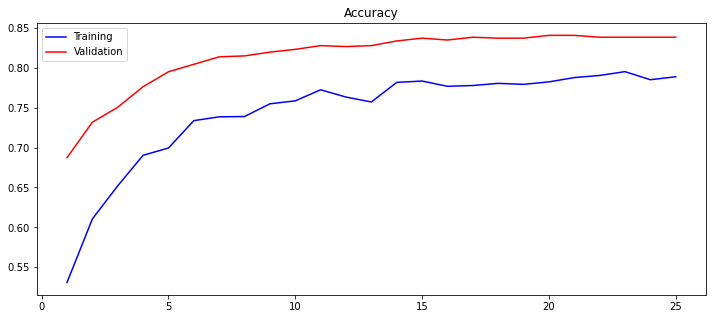

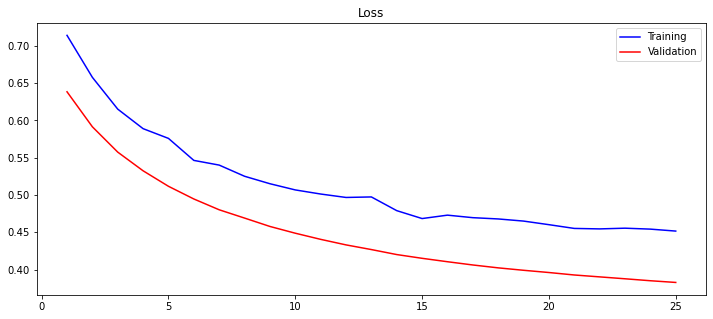

In [34]:
learn_model(2e-5)

Step 2

In [35]:
# Load model with the best result
try:
    model.load_weights('/kaggle/working/best_model.hdf5')
except:
    pass

# Freeze all the layers before the `fine_tune_at` layer number
base_model.trainable = True
fine_tune_at = int(len(base_model.layers) / 1.1)
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 8, 8, 1792)        17673823  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1792)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               918016    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 18,592,352
Trainable params: 6,907,097
Non-trainable params: 11,685,255
____________________________________

Epoch 1/40
76/76 [==============================] - 110s 1s/step - loss: 0.5269 - accuracy: 0.7411 - val_loss: 0.4118 - val_accuracy: 0.8255

Epoch 00001: val_accuracy did not improve from 0.84075
Epoch 2/40
76/76 [==============================] - 96s 1s/step - loss: 0.5256 - accuracy: 0.7414 - val_loss: 0.4182 - val_accuracy: 0.8232

Epoch 00002: val_accuracy did not improve from 0.84075
Epoch 3/40
76/76 [==============================] - 96s 1s/step - loss: 0.4985 - accuracy: 0.7632 - val_loss: 0.4161 - val_accuracy: 0.8244

Epoch 00003: val_accuracy did not improve from 0.84075
Epoch 4/40
76/76 [==============================] - 97s 1s/step - loss: 0.4784 - accuracy: 0.7771 - val_loss: 0.4082 - val_accuracy: 0.8337

Epoch 00004: val_accuracy did not improve from 0.84075
Epoch 5/40
76/76 [==============================] - 96s 1s/step - loss: 0.4698 - accuracy: 0.7847 - val_loss: 0.3996 - val_accuracy: 0.8396

Epoch 00005: val_accuracy did not improve from 0.84075
Epoch 6/40
76/76 [=

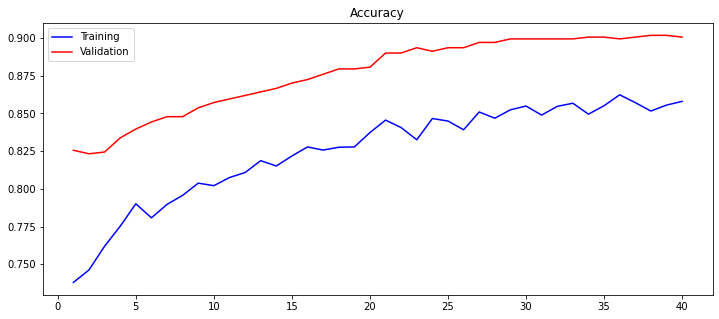

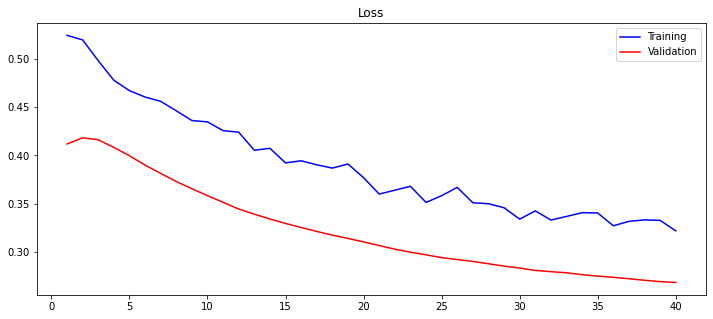

In [36]:
learn_model(5e-6)

Step 3

In [37]:
# Decrease batch size to 32
train_generator = train_datagen.flow_from_dataframe(
    df_train,
    IMAGE_PATH,
    'name',
    'label',
    class_mode='binary',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    shuffle=True,
)

Found 4835 validated image filenames belonging to 2 classes.


In [38]:
# Load model with the best result
try:
    model.load_weights('/kaggle/working/best_model.hdf5')
except ValueError:
    base_model.trainable = False
    try:
        model.load_weights('/kaggle/working/best_model.hdf5')
    except:
        pass
    
# Define all layers as trainable
base_model.trainable = True

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 8, 8, 1792)        17673823  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1792)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               918016    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 18,592,352
Trainable params: 18,467,145
Non-trainable params: 125,207
______________________________________

Epoch 1/40
152/152 [==============================] - 147s 864ms/step - loss: 0.4546 - accuracy: 0.7812 - val_loss: 0.3387 - val_accuracy: 0.8583

Epoch 00001: val_accuracy did not improve from 0.90164
Epoch 2/40
152/152 [==============================] - 128s 842ms/step - loss: 0.4655 - accuracy: 0.7739 - val_loss: 0.3629 - val_accuracy: 0.8419

Epoch 00002: val_accuracy did not improve from 0.90164
Epoch 3/40
152/152 [==============================] - 127s 835ms/step - loss: 0.4739 - accuracy: 0.7845 - val_loss: 0.3709 - val_accuracy: 0.8361

Epoch 00003: val_accuracy did not improve from 0.90164
Epoch 4/40
152/152 [==============================] - 128s 841ms/step - loss: 0.4502 - accuracy: 0.7812 - val_loss: 0.3721 - val_accuracy: 0.8326

Epoch 00004: val_accuracy did not improve from 0.90164
Epoch 5/40
152/152 [==============================] - 128s 840ms/step - loss: 0.4416 - accuracy: 0.7857 - val_loss: 0.3720 - val_accuracy: 0.8337

Epoch 00005: val_accuracy did not improve fro

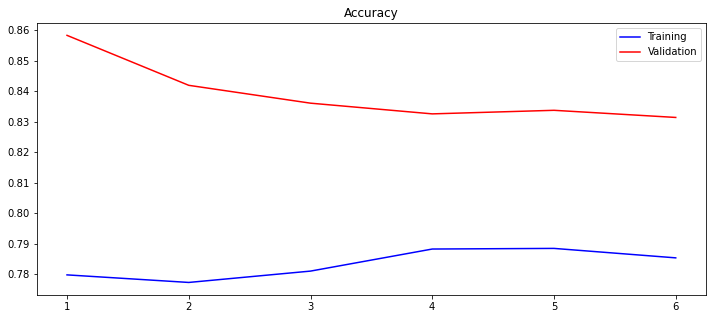

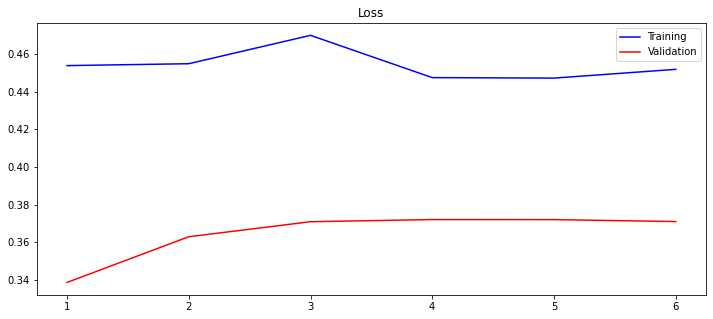

In [39]:
learn_model(1e-7)

# Evaluation of the model

In [40]:
# Load model with the best result
try:
    model.load_weights('/kaggle/working/best_model.hdf5')
except ValueError:
    base_model.trainable = True
    fine_tune_at = int(len(base_model.layers) / 1.1)
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    try:
        model.load_weights('/kaggle/working/best_model.hdf5')
    except ValueError:
        base_model.trainable = False
        try:
            model.load_weights('/kaggle/working/best_model.hdf5')
        except:
            pass
    
# Compile the model
model.compile(loss='binary_crossentropy', metrics=['accuracy'])

# Compute score
scores = model.evaluate(test_generator)
print("Validation accuracy: %.2f %%" % (scores[1]*100))

14/14 [==============================] - 14s 753ms/step - loss: 0.2807 - accuracy: 0.8974
Validation accuracy: 90.16 %


In [41]:
# Clean WORKING_PATH
shutil.rmtree(WORKING_PATH)